# Titanic

## Data Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')
train_set.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


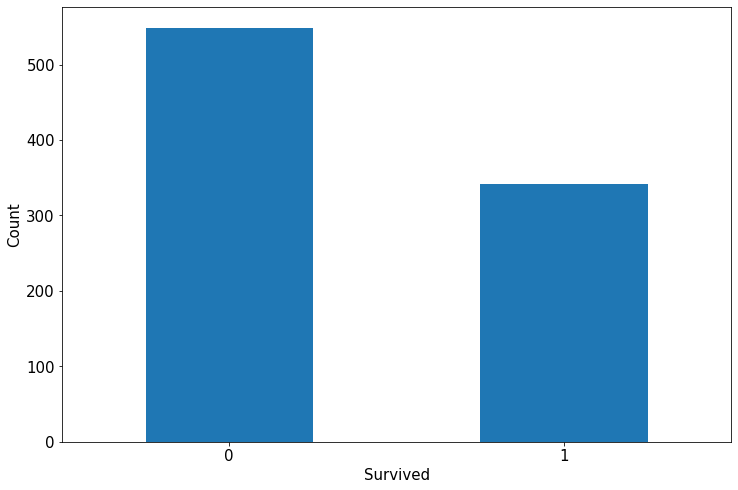

In [2]:
%matplotlib inline
%config InlineBackEnd.figure_format = 'png'
ax = train_set['Survived'].value_counts().plot(kind='bar', figsize=(12,8), fontsize=15, rot=0)
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('Survived', fontsize=15)
plt.show()

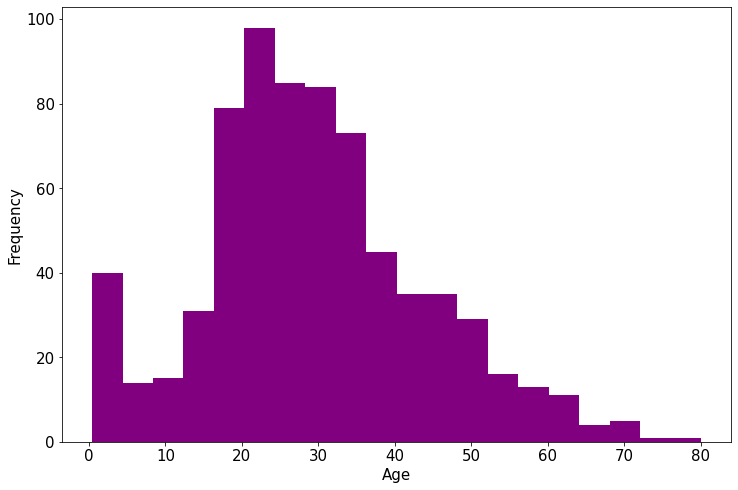

In [3]:
%matplotlib inline
%config InlineBackEnd.figure_format = 'png'
ax = train_set['Age'].plot(kind='hist', bins=20, color='purple', figsize=(12,8), fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.set_xlabel('Age', fontsize=15)
plt.show()

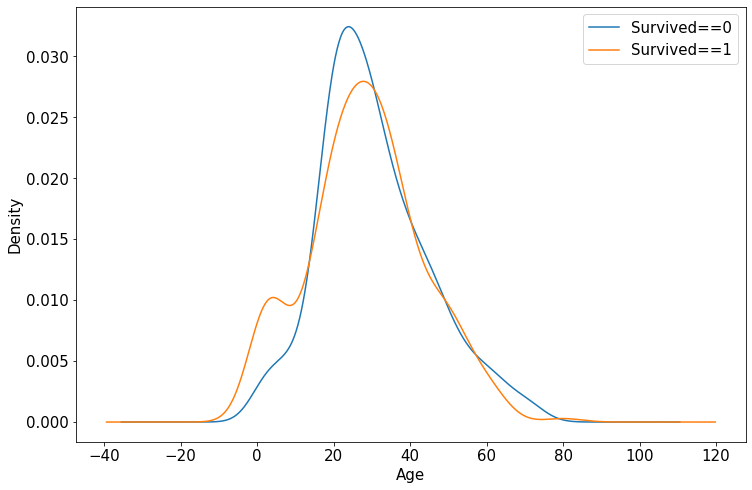

In [4]:
%matplotlib inline
%config InlineBackEnd.figure_format = 'png'
ax = train_set.query('Survived == 0')['Age'].plot(kind='density', figsize=(12,8), fontsize=15)
train_set.query('Survived == 1')['Age'].plot(kind='density', figsize=(12,8), fontsize=15)
ax.legend(['Survived==0', 'Survived==1'], fontsize=15)
ax.set_ylabel('Density', fontsize=15)
ax.set_xlabel('Age', fontsize=15)
plt.show()

In [5]:
def prepocessing(data):
  result = pd.DataFrame()

  # Pclass
  pclass = pd.get_dummies(data['Pclass'])
  pclass.columns = ['Pclass_' + str(x) for x in pclass.columns]
  result = pd.concat([result, pclass], axis=1)

  # Sex
  sex = pd.get_dummies(data['Sex'])
  result = pd.concat([result, sex], axis=1)

  # Age
  result['Age'] = data['Age'].fillna(0)
  result['Age_null'] = pd.isna(data['Age']).astype('int32')

  # SibSp, Parch, Fare
  result['SibSp'] = data['SibSp']
  result['Parch'] = data['Parch']
  result['Fare'] = data['Fare']

  # Cabin
  result['Cabin_null'] = pd.isna(data['Cabin']).astype('int32')

  # Embarked
  embarked = pd.get_dummies(data['Embarked'], dummy_na=True)
  embarked.columns = ['Embarked_' + str(x) for x in embarked.columns]
  result = pd.concat([result, embarked], axis=1)

  return result

x_train = prepocessing(train_set)
y_train = train_set['Survived'].values

x_test = prepocessing(test_set)
# y_test = test_set['Survived'].values

print('Trainset shape is', x_train.shape)
print('Testset shape is', x_test.shape)

Trainset shape is (891, 15)
Testset shape is (418, 15)


## Define Model

In [6]:
# Destroys the current TF graph and creates a new one.
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(15,)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [7]:
# AUC: Computes the approximate AUC (Area under the curve) via a Riemann sum.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

history = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_split=0.2)

Epoch 1/30
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
12/12 [==============================] - 0s 24ms/step - loss: 2.4525 - auc: 0.6134 - val_loss: 1.6605 - val_auc: 0.6533
Epoch 2/30
12/12 [==============================] - 0s 4ms/step - loss: 1.5651 - auc: 0.6581 - val_loss: 0.9689 - val_auc: 0.6740
Epoch 3/30
12/12 [==============================] - 0s 4ms/step - loss: 0.8869 - auc: 0.6482 - val_loss: 0.6157 - val_auc: 0.7073
Epoch 4/30
12/12 [==============================] - 0s 4ms/step - loss: 0.6735 - auc: 0.5767 - val_loss: 0.6669 - val_auc: 0.5843
Epoch 5/30
12/12 [==============================] - 0s 5ms/step - loss: 0.6560 - auc: 0.6261 - val_loss: 0.5872 - val_auc: 0.7137
Epoch 6/30
12/12 [==============================] - 0s 4ms/step - loss: 0.6220 - auc: 0.6907 - val_loss: 0.5752 - val_auc: 0.7400
Epoch 7/30
12/12 [==============================] - 0s 4ms/step - loss: 0.6579 - auc: 0.7032 - val_loss: 0.5702 - val_auc: 0.7521
Epoch 8/

## Evaluate Model

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_metric(history, metric):
  train_metric = history.history[metric]
  val_metric = history.history['val_' + metric]
  epochs = range(1, len(train_metric) + 1)
  plt.plot(epochs, train_metric, 'bo--')
  plt.plot(epochs, val_metric, 'ro-')
  plt.title('Training and validation ' + metric)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.legend(['train_'+metric, 'val_'+metric])
  plt.show()

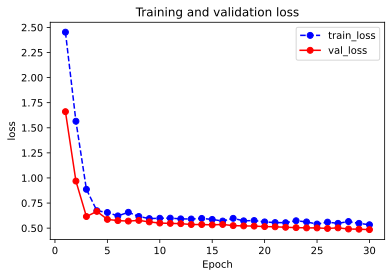

In [9]:
plot_metric(history, 'loss')

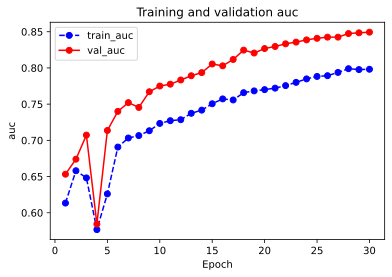

In [10]:
plot_metric(history, 'auc')

In [11]:
model.evaluate(x=x_train, y=y_train)

28/28 [==============================] - 0s 1ms/step - loss: 0.5305 - auc: 0.8100


[0.5305385589599609, 0.8100240230560303]

## Use Model

In [12]:
# Generates output predictions for the input samples.
model.predict(x_test[0:10])

array([[0.18679616],
       [0.21850097],
       [0.17066541],
       [0.2185182 ],
       [0.36208564],
       [0.29110336],
       [0.32101196],
       [0.43702984],
       [0.3849838 ],
       [0.3126194 ]], dtype=float32)

In [13]:
# Generate class predictions for the input samples batch by batch.
model.predict_classes(x_test[0:10])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [14]:
# Generate submission file
submission = pd.DataFrame()
submission['PassengerId'] = test_set['PassengerId']
submission['Survived'] = model.predict_classes(x_test)
submission.to_csv('submission.csv', index=False)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:363: RuntimeWarning: invalid value encountered in greater
  return (proba > 0.5).astype('int32')


## Save Model

In [15]:
# Save model architecture & weights
model.save('keras_model.h5')

del model

# Load model
model = models.load_model('keras_model.h5')
model.evaluate(x_train, y_train)

28/28 [==============================] - 0s 1ms/step - loss: 0.5305 - auc: 0.8100


[0.5305385589599609, 0.8100240230560303]

In [16]:
# Save model architecture
json_str = model.to_json()
# Save model weights
model.save_weights('keras_model_weights.h5')

# Load model
model_json = models.model_from_json(json_str)
model_json.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model_json.load_weights('keras_model_weights.h5')
model_json.evaluate(x_train, y_train)

28/28 [==============================] - 0s 1ms/step - loss: 0.5305 - auc: 0.8100


[0.5305385589599609, 0.8100240230560303]

In [17]:
# Save model in Tensorflow format
model.save_weights('tf_model_weights.ckpt', save_format='tf')
model.save('tf_model', save_format='tf')
# Load model
model_loaded = models.load_model('tf_model')
model_loaded.evaluate(x_train, y_train)

INFO:tensorflow:Assets written to: tf_model/assets
28/28 [==============================] - 0s 1ms/step - loss: 0.5305 - auc: 0.8100


[0.5305385589599609, 0.8100240230560303]